# Weather Pattern Clustering

The weather datasets downloaded from NREL contain measurements of 19 different attributes taken at half-hour increments from various locations in and arround Pittsburgh, PA. I will attempt to explore these datasets through visualization first, and then through clustering. The ultimate goal is to be able to predict how weather patterns change, specifically GHI for solar power production. 

First, I will analyze just the Pittsburgh weather data.

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

# Load Pittsburgh-only data
with open('PIT_dict.pkl', 'rb') as f:
    PIT_dict = pickle.load(f)

PIT_df = PIT_dict['complete_data']
# Use only the weather-related columns, not time
cols = list(PIT_df.columns)
cols.remove('Month')
cols.remove('Day')
cols.remove('Hour')
cols.remove('Minute')

PIT_weather = PIT_df[cols]
PIT_weather.head()


,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,PIT_Global Horizontal UV Irradiance (280-400nm),PIT_Global Horizontal UV Irradiance (295-385nm)
0,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.30,-11.0,990,0.0,0.0
1,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.32,-11.0,990,0.0,0.0
2,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.56,-11.0,990,0.0,0.0
3,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.57,-11.0,990,0.0,0.0
4,0,0,0,0,0,0,-14.0,0.866,-0.430146,-0.418299,78.91,-12.0,990,0.0,0.0


## Data Visualization

I will now look at the distribution of a select few attributes.

In [172]:
# Get min and max values for each attribute of interest
DHI_min = PIT_weather["PIT_DHI"].min()
DNI_min = PIT_weather["PIT_DNI"].min()
GHI_min = PIT_weather["PIT_GHI"].min()
DHI_max = PIT_weather["PIT_DHI"].max()
DNI_max = PIT_weather["PIT_DNI"].max()
GHI_max = PIT_weather["PIT_GHI"].max()

Wind_X_min = PIT_weather["PIT_Wind_X"].min()
Wind_Y_min = PIT_weather["PIT_Wind_Y"].min()
Wind_X_max = PIT_weather["PIT_Wind_X"].max()
Wind_Y_max = PIT_weather["PIT_Wind_Y"].max()

Temp_min = PIT_weather["PIT_Temperature"].min()
DP_min = PIT_weather["PIT_Dew Point"].min()
RH_min = PIT_weather["PIT_Relative Humidity"].min()
Temp_max = PIT_weather["PIT_Temperature"].max()
DP_max = PIT_weather["PIT_Dew Point"].max()
RH_max = PIT_weather["PIT_Relative Humidity"].max()

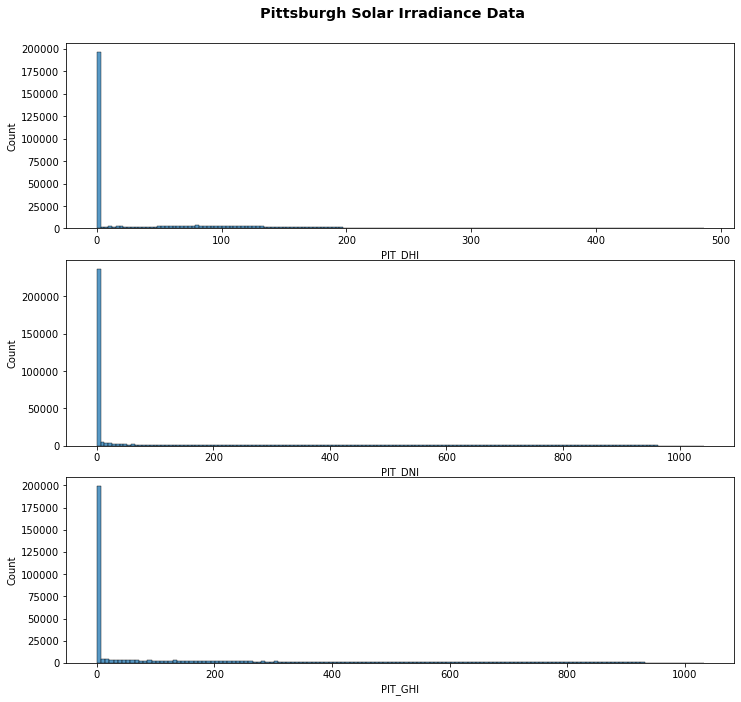

In [207]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Solar Irradiance Data', weight='bold', size='x-large')

sns.histplot(data=PIT_weather, x='PIT_DHI', ax=axs[0])
sns.histplot(data=PIT_weather, x='PIT_DNI', ax=axs[1])
sns.histplot(data=PIT_weather, x='PIT_GHI', ax=axs[2])
plt.show()

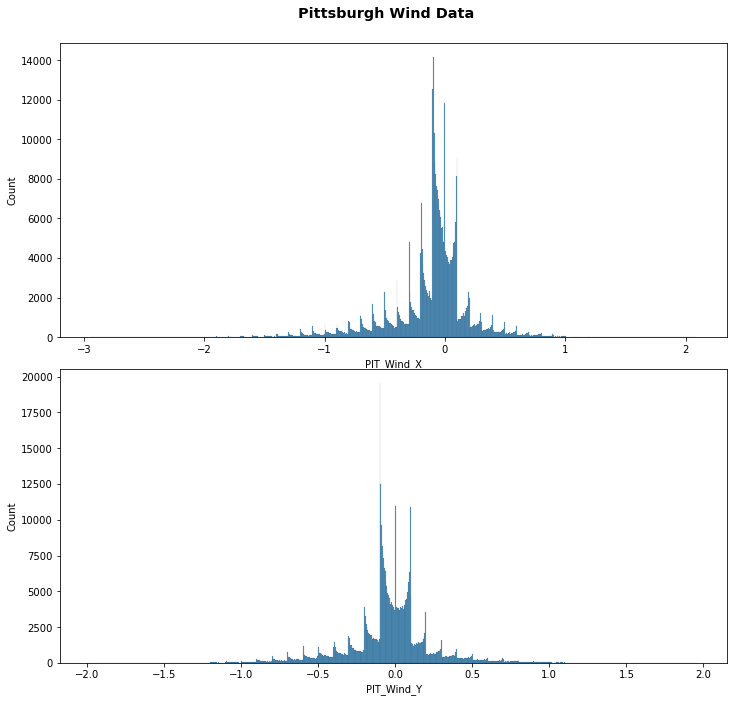

In [206]:
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Wind Data', weight='bold', size='x-large')

sns.histplot(data=PIT_weather, x='PIT_Wind_X', ax=axs[0])
sns.histplot(data=PIT_weather, x='PIT_Wind_Y', ax=axs[1])
plt.show()

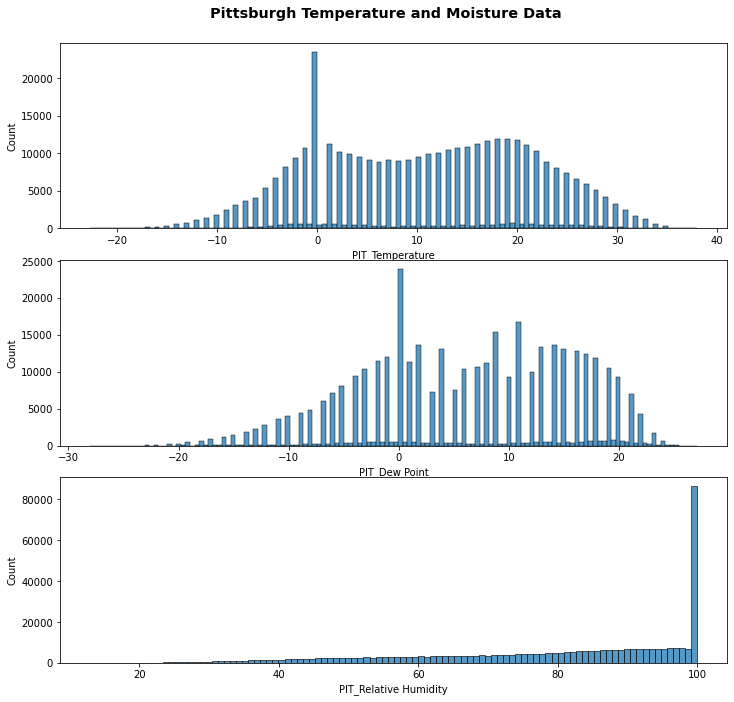

In [205]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Temperature and Moisture Data', weight='bold', size='x-large')

sns.histplot(data=PIT_weather, x='PIT_Temperature', ax=axs[0])
sns.histplot(data=PIT_weather, x='PIT_Dew Point', ax=axs[1])
sns.histplot(data=PIT_weather, x='PIT_Relative Humidity', ax=axs[2])
plt.show()

Some features to take note of in these distributions are first, the very high prominence of zero values in all of the solar irradiance data columns. These are largely due to measurements made at night. 

The wind data has an interesting bimodal distribution with most of the data showing wind from the west and the south.

The temperature, dew point, and relative humidity data all have sharp peaks at 0 (for temperature and dew point) and 100 (for relative humidity). These seem to be due to incorrectly recorded data as these peaks don't seem to make much sense. However, it would be difficult to sort out the correct data from the erroneous data so I will leave it be for now. 

# Clustering

Now I will attempt to cluster the Pittsburgh weather data into discrete groups. First, the data needs to all be adjusted to be on similar scales. We don't want one feature having a range of 1000 and another a range of 100. I will use a simple min-max scaler to bring all data between 0 and 1.

In [101]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_PIT_weather = scaler.fit_transform(PIT_weather)

Now it's time to cluster the data. To select the number of clusters, I will use the elbow method. The KMeans algorithm will be applied multiple times, with different k values each time and the inertia value for each iteration saved. These inertia values will then be plotted to see where the inertia starts leveling off.

In [102]:
from sklearn.cluster import KMeans

sum_of_squared_distances = []

K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(scaled_PIT_weather)
    sum_of_squared_distances.append(k_means.inertia_)

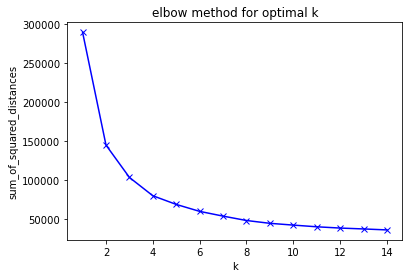

In [103]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

From this plot, it appears that a k value of 4 may be the optimal selection.

I will display the centers of each of these clusters below.

In [104]:
k_means = KMeans(n_clusters=4, random_state=15217)
model = k_means.fit(scaled_PIT_weather)
centers = scaler.inverse_transform(model.cluster_centers_)


In [105]:
#function that creates a dataframe with a column for cluster number
def pd_centers(cols_of_interest, centers):
        colNames = list(cols_of_interest)
        colNames.append('prediction')
# Zip with a column called 'prediction' (index)
        Z = [np.append(A, index) for index, A in enumerate(centers)]
# Convert to pandas data frame for plotting
        P = pd.DataFrame(Z, columns=colNames)
        P['prediction'] = P['prediction'].astype(int)
        return P
P = pd_centers(PIT_weather.columns, centers)
P

,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,PIT_Global Horizontal UV Irradiance (280-400nm),PIT_Global Horizontal UV Irradiance (295-385nm),prediction
0,38.778586,80.156847,64.605993,37.750854,216.582498,117.359271,-6.579918,0.857934,-0.353064,-0.038949,82.264109,-3.877215,981.266648,3.204748,2.489990,0
1,199.642219,641.385969,650.203504,140.274303,804.567602,723.243695,8.795406,0.158393,-0.114709,-0.017750,50.598384,20.680528,981.888978,37.975190,29.821960,1
2,5.081155,14.177200,6.783676,7.610229,36.209434,13.418060,7.695568,0.114301,-0.054424,-0.046278,91.734156,9.657681,980.824564,0.140663,0.107833,2
3,142.405820,216.544722,221.937149,120.973690,640.833541,439.307083,8.672401,0.118229,-0.114788,-0.045750,72.554528,14.614520,979.944025,12.315991,9.604281,3


It appears that the solar irradiance is a large factor in separating these clusters. Let's find the assigned cluster of each datapoint and inspect the distribution of the same attributes viewed before for each cluster.

In [132]:
predict = model.predict(scaled_PIT_weather)
predict = pd.Series(predict, index=PIT_weather.index)
PIT_weather['Cluster'] = predict
PIT_weather.head()

/Users/john/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,PIT_Global Horizontal UV Irradiance (280-400nm),PIT_Global Horizontal UV Irradiance (295-385nm),Cluster
0,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.30,-11.0,990,0.0,0.0,0
1,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.32,-11.0,990,0.0,0.0,0
2,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.56,-11.0,990,0.0,0.0,0
3,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.57,-11.0,990,0.0,0.0,0
4,0,0,0,0,0,0,-14.0,0.866,-0.430146,-0.418299,78.91,-12.0,990,0.0,0.0,0


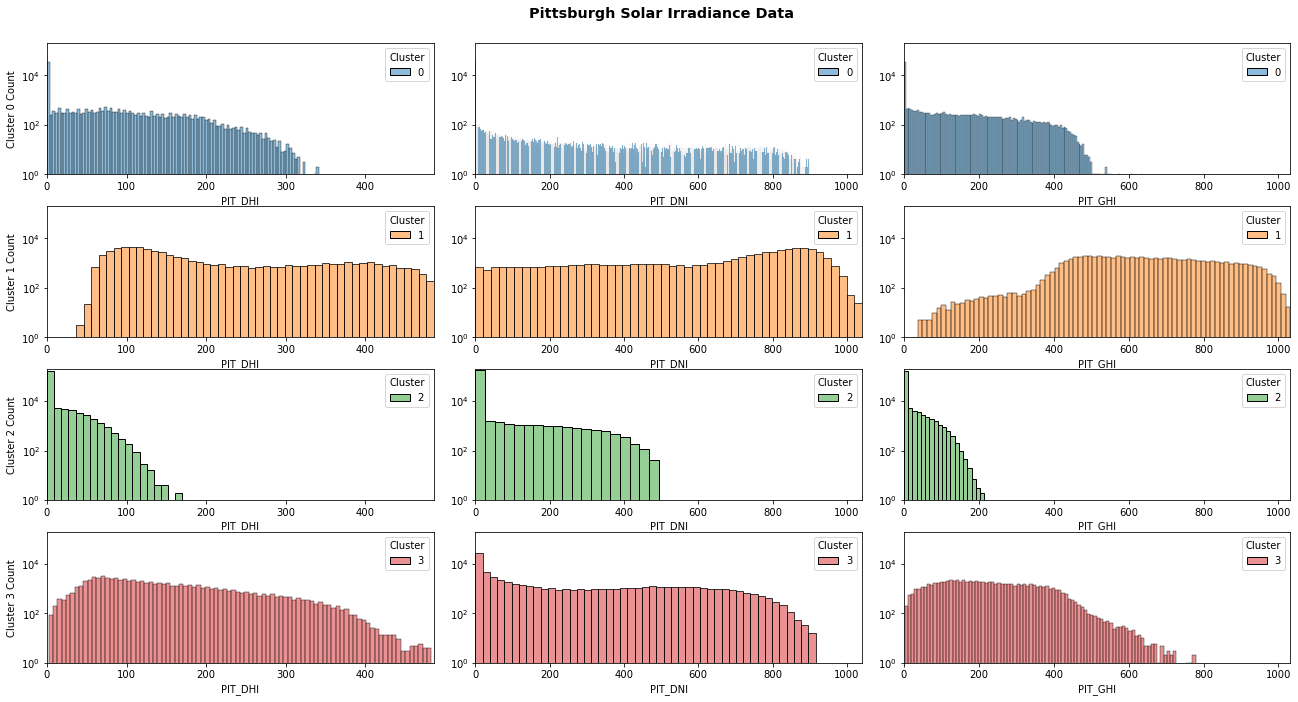

In [202]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Solar Irradiance Data', weight='bold', size='x-large')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_DHI', ax=axs[0,0], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DHI_min, DHI_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_DNI', ax=axs[0,1], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DNI_min, DNI_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_GHI', ax=axs[0,2], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(GHI_min, GHI_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_DHI', ax=axs[1,0], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DHI_min, DHI_max), ylim=(1,200000), ylabel='Cluster 1 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_DNI', ax=axs[1,1], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DNI_min, DNI_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_GHI', ax=axs[1,2], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(GHI_min, GHI_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_DHI', ax=axs[2,0], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DHI_min, DHI_max), ylim=(1,200000), ylabel='Cluster 2 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_DNI', ax=axs[2,1], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DNI_min, DNI_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_GHI', ax=axs[2,2], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(GHI_min, GHI_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_DHI', ax=axs[3,0], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DHI_min, DHI_max), ylim=(1,200000), ylabel='Cluster 3 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_DNI', ax=axs[3,1], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DNI_min, DNI_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_GHI', ax=axs[3,2], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(GHI_min, GHI_max), ylim=(1,200000), ylabel='')

plt.show()

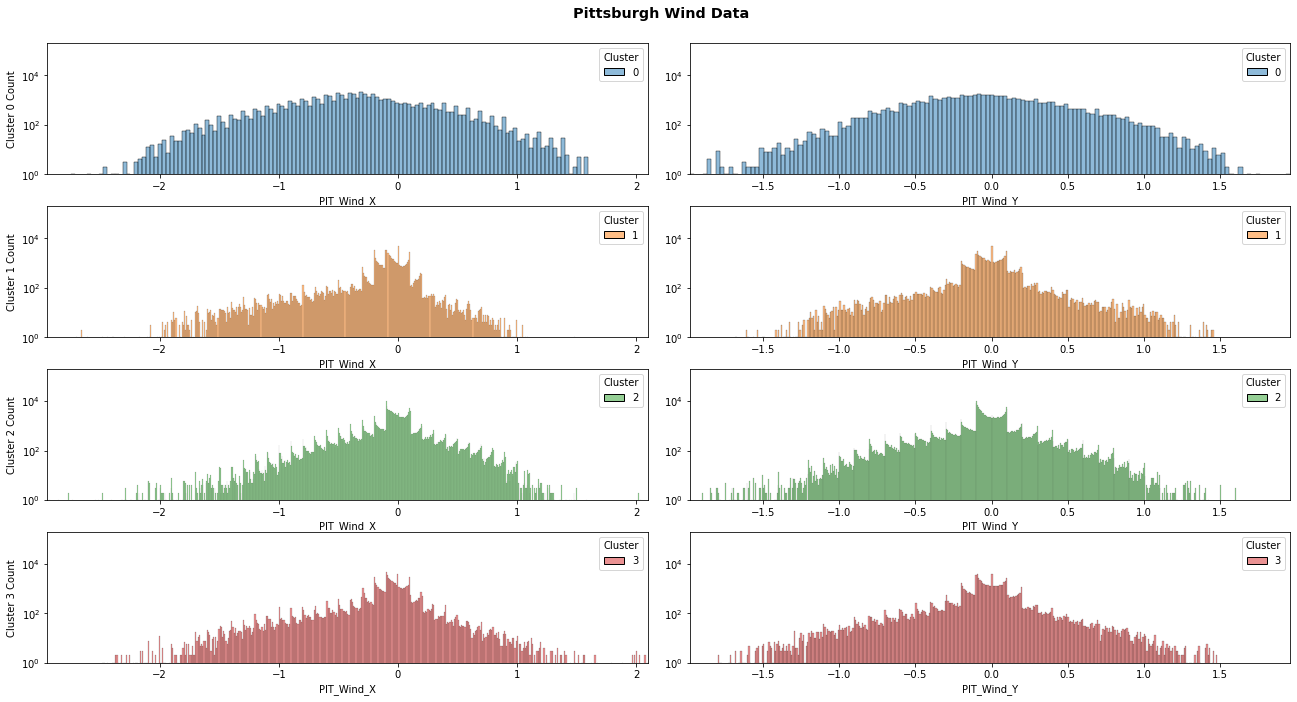

In [201]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Wind Data', weight='bold', size='x-large')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Wind_X', ax=axs[0,0], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_X_min, Wind_X_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Wind_Y', ax=axs[0,1], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_Y_min, Wind_Y_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Wind_X', ax=axs[1,0], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_X_min, Wind_X_max), ylim=(1,200000), ylabel='Cluster 1 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Wind_Y', ax=axs[1,1], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_Y_min, Wind_Y_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Wind_X', ax=axs[2,0], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_X_min, Wind_X_max), ylim=(1,200000), ylabel='Cluster 2 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Wind_Y', ax=axs[2,1], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_Y_min, Wind_Y_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Wind_X', ax=axs[3,0], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_X_min, Wind_X_max), ylim=(1,200000), ylabel='Cluster 3 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Wind_Y', ax=axs[3,1], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_Y_min, Wind_Y_max), ylim=(1,200000), ylabel='')
    
plt.show()

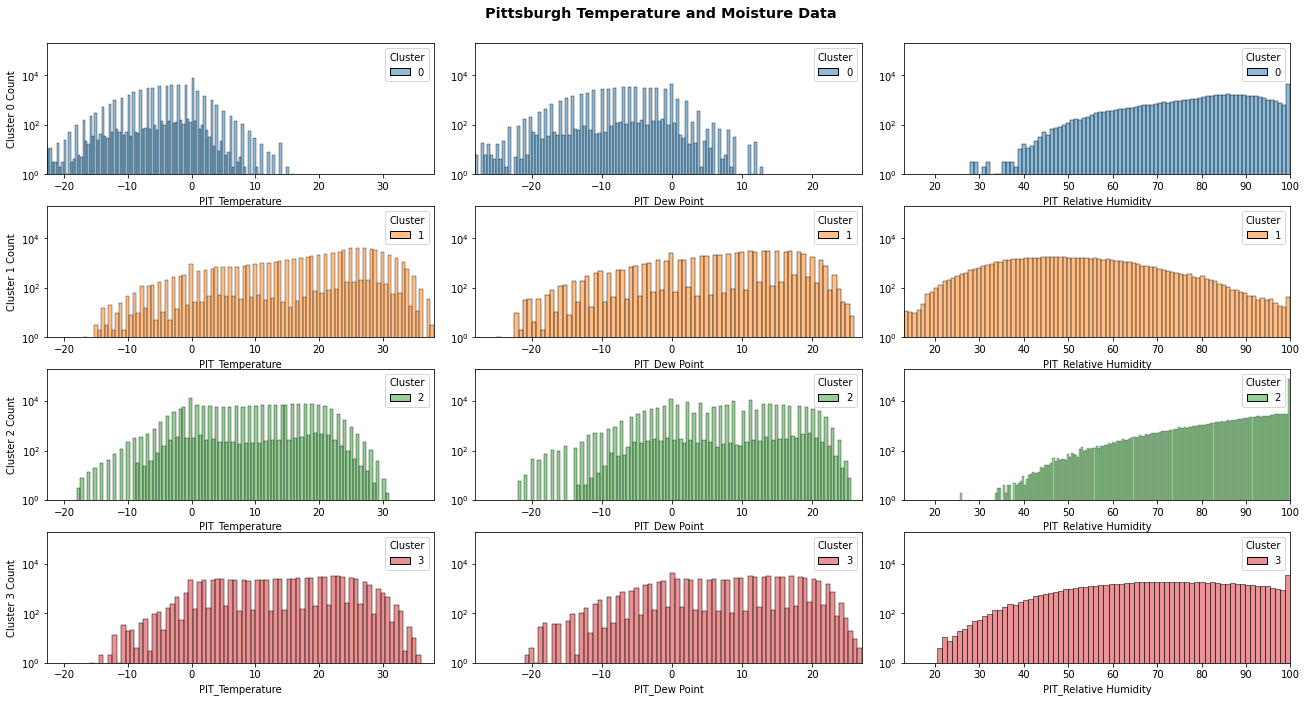

In [200]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Temperature and Moisture Data', weight='bold', size='x-large')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Temperature', ax=axs[0,0], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Temp_min, Temp_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Dew Point', ax=axs[0,1], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DP_min, DP_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Relative Humidity', ax=axs[0,2], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(RH_min, RH_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Temperature', ax=axs[1,0], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Temp_min, Temp_max), ylim=(1,200000), ylabel='Cluster 1 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Dew Point', ax=axs[1,1], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DP_min, DP_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Relative Humidity', ax=axs[1,2], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(RH_min, RH_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Temperature', ax=axs[2,0], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Temp_min, Temp_max), ylim=(1,200000), ylabel='Cluster 2 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Dew Point', ax=axs[2,1], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DP_min, DP_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Relative Humidity', ax=axs[2,2], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(RH_min, RH_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Temperature', ax=axs[3,0], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Temp_min, Temp_max), ylim=(1,200000), ylabel='Cluster 3 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Dew Point', ax=axs[3,1], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DP_min, DP_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Relative Humidity', ax=axs[3,2], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(RH_min, RH_max), ylim=(1,200000), ylabel='')

plt.show()

On a log scale, it may be a bit difficult to determine the relative sizes of the clusters. We can count how many members are in each cluster and list them.

In [218]:
count_0 = (PIT_weather["Cluster"] == 0).sum()
count_1 = (PIT_weather["Cluster"] == 1).sum()
count_2 = (PIT_weather["Cluster"] == 2).sum()
count_3 = (PIT_weather["Cluster"] == 3).sum()

print(f'Cluster 0 has {count_0:,} members\n\
Cluster 1 has {count_1:,} members\n\
Cluster 2 has {count_2:,} members\n\
Cluster 3 has {count_3:,} members\n')

Cluster 0 has 52,409 members
Cluster 1 has 63,731 members
Cluster 2 has 191,531 members
Cluster 3 has 77,769 members



Now I'm interested in the transition probabilities between clusters over a one-hour time period.

In [687]:
# Transition matrix. Rows are FROM and columns are TO
# hourly_transitions[2, 1] is the number of transitions FROM cluster 2 TO cluster 1
hourly_transitions = np.zeros((4, 4))

for i in range(2, PIT_weather['Cluster'].shape[0]):
    cluster_from = PIT_weather['Cluster'][i-2]
    cluster_to = PIT_weather['Cluster'][i]
    hourly_transitions[cluster_from, cluster_to] += 1

hourly_transitions

array([[ 50954.,    992.,    330.,    133.],
       [  1003.,  50323.,      1.,  12404.],
       [   328.,      0., 177475.,  13726.],
       [   122.,  12416.,  13725.,  51506.]])

In [688]:
hourly_transitions_norm = hourly_transitions / hourly_transitions.sum(axis=1)[:,None]
np.set_printoptions(suppress=True)
hourly_transitions_norm

array([[0.9722, 0.0189, 0.0063, 0.0025],
       [0.0157, 0.7896, 0.    , 0.1946],
       [0.0017, 0.    , 0.9266, 0.0717],
       [0.0016, 0.1597, 0.1765, 0.6623]])

From this we see that cluster 1 and cluster 3 are the most likely to transition to themselves. The inter-cluster transition with the highest probability is 2 -> 3 followed by 3 -> 2 and 3 -> 1.

In [690]:
hourly_transitions.sum(axis=1)

array([ 52409.,  63731., 191529.,  77769.])

## Visualization of Hourly Cluster Transitions

The following plot displays the transition probabilities between clusters over an hour. The size of the clusters is proportional to the number of instances in that cluster. The arrow sizes are proportional to the conditional probability of that transition given the initial instance is in the starting cluster.

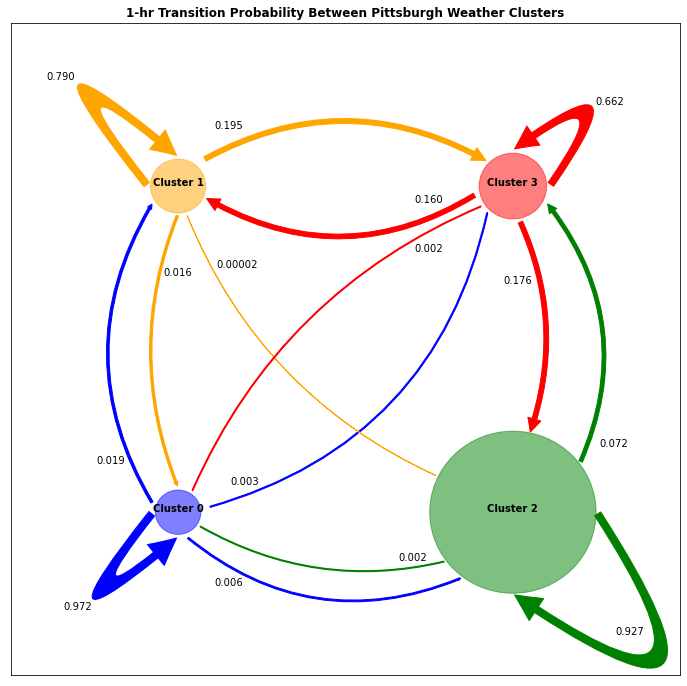

In [691]:
import matplotlib.patches as patches

total_count = count_0 + count_1 + count_2 + count_3
norm_count_0 = count_0/total_count
norm_count_1 = count_1/total_count
norm_count_2 = count_2/total_count
norm_count_3 = count_3/total_count

cluster0 = plt.Circle((0,0), norm_count_0, color='b', alpha=0.5)
cluster1 = plt.Circle((0,2), norm_count_1, color='orange', alpha=0.5)
cluster2 = plt.Circle((2,0), norm_count_2, color='g', alpha=0.5)
cluster3 = plt.Circle((2,2), norm_count_3, color='r', alpha=0.5)

fig, ax = plt.subplots(figsize=(12,12))

ax.add_artist(cluster0)
plt.text(0, 0, "Cluster 0", horizontalalignment='center', fontweight='bold')
ax.add_artist(cluster1)
plt.text(0, 2, "Cluster 1", horizontalalignment='center', fontweight='bold')
ax.add_artist(cluster2)
plt.text(2, 0, "Cluster 2", horizontalalignment='center', fontweight='bold')
ax.add_artist(cluster3)
plt.text(2, 2, "Cluster 3", horizontalalignment='center', fontweight='bold')

tw_mult = 3
hw_mult = 5
hl_mult = 5

from numpy import errstate,isneginf,isinf,array

with errstate(divide='ignore'):
    tw = np.log10(hourly_transitions_norm)
    hw = np.log10(hourly_transitions_norm)
    hl = np.log10(hourly_transitions_norm)


tw[isneginf(tw)] = np.inf
hw[isneginf(hw)] = np.inf
hl[isneginf(hl)] = np.inf

tw += (-(tw.min()) + 1)
hw += (-(hw.min()) + 1)
hl += (-(hl.min()) + 1)

tw[isinf(tw)] = 0
hw[isinf(hw)] = 0
hl[isinf(hl)] = 0

tw = (tw/3)**tw_mult
hw = (hw/3)**hw_mult
hl = (hl/3)**hl_mult

zero_zero= patches.FancyArrowPatch((-0.15, 0), (0, -0.15), color='b',
                                   arrowstyle=f"simple, tail_width={tw[0,0]}, head_width={hw[0,0]}, head_length={hl[0,0]}", 
                                   connectionstyle='arc3,rad=5')
zero_one = patches.FancyArrowPatch((-0.15, 0.05), (-0.15, 1.9), color='b',
                                   arrowstyle=f"simple, tail_width={tw[0,1]}, head_width={hw[0,1]}, head_length={hl[0,1]}", 
                                   connectionstyle='arc3,rad=-0.3')
zero_two = patches.FancyArrowPatch((0.05, -0.15), (1.7, -0.4), color='b',
                                   arrowstyle=f"simple, tail_width={tw[0,2]}, head_width={hw[0,2]}, head_length={hl[0,2]}", 
                                   connectionstyle='arc3,rad=0.3')
zero_three = patches.FancyArrowPatch((0.18, 0.03), (1.85, 1.85), color='b',
                                   arrowstyle=f"simple, tail_width={tw[0,3]}, head_width={hw[0,3]}, head_length={hl[0,3]}", 
                                   connectionstyle='arc3,rad=0.3')

one_zero= patches.FancyArrowPatch((0, 1.83), (0, 0.15), color='orange',
                                   arrowstyle=f"simple, tail_width={tw[1,0]}, head_width={hw[1,0]}, head_length={hl[1,0]}", 
                                   connectionstyle='arc3,rad=0.2')
one_one = patches.FancyArrowPatch((-0.18, 2), (0, 2.18), color='orange',
                                   arrowstyle=f"simple, tail_width={tw[1,1]}, head_width={hw[1,1]}, head_length={hl[1,1]}", 
                                   connectionstyle='arc3,rad=-5')
one_two = patches.FancyArrowPatch((0.05, 1.83), (1.55, 0.22), color='orange',
                                   arrowstyle=f"simple, tail_width={tw[1,2]}, head_width={hw[1,2]}, head_length={hl[1,2]}", 
                                   connectionstyle='arc3,rad=0.2')
one_three = patches.FancyArrowPatch((0.15, 2.16), (1.85, 2.15), color='orange',
                                   arrowstyle=f"simple, tail_width={tw[1,3]}, head_width={hw[1,3]}, head_length={hl[1,3]}", 
                                   connectionstyle='arc3,rad=-0.28')

two_zero= patches.FancyArrowPatch((1.6, -0.3), (0.12, -0.08), color='g',
                                   arrowstyle=f"simple, tail_width={tw[2,0]}, head_width={hw[2,0]}, head_length={hl[2,0]}", 
                                   connectionstyle='arc3,rad=-0.2')
two_one = patches.FancyArrowPatch((2, 0), (0, 2.18), color='g',
                                   arrowstyle=f"simple, tail_width={tw[2,1]}, head_width={hw[2,1]}, head_length={hl[2,1]}", 
                                   connectionstyle='arc3,rad=-5')
two_two = patches.FancyArrowPatch((2.5, 0), (2, -0.5), color='g',
                                   arrowstyle=f"simple, tail_width={tw[2,2]}, head_width={hw[2,2]}, head_length={hl[2,2]}", 
                                   connectionstyle='arc3,rad=-2.5')
two_three = patches.FancyArrowPatch((2.4, 0.3), (2.2, 1.9), color='g',
                                   arrowstyle=f"simple, tail_width={tw[2,3]}, head_width={hw[2,3]}, head_length={hl[2,3]}", 
                                   connectionstyle='arc3,rad=0.3')

three_zero= patches.FancyArrowPatch((1.82, 1.88), (0.08, 0.12), color='r',
                                   arrowstyle=f"simple, tail_width={tw[3,0]}, head_width={hw[3,0]}, head_length={hl[3,0]}", 
                                   connectionstyle='arc3,rad=0.2')
three_one = patches.FancyArrowPatch((1.78, 1.95), (0.16, 1.93), color='r',
                                   arrowstyle=f"simple, tail_width={tw[3,1]}, head_width={hw[3,1]}, head_length={hl[3,1]}", 
                                   connectionstyle='arc3,rad=-0.3')
three_two = patches.FancyArrowPatch((2.04, 1.79), (2.1, 0.48), color='r',
                                   arrowstyle=f"simple, tail_width={tw[3,2]}, head_width={hw[3,2]}, head_length={hl[3,2]}", 
                                   connectionstyle='arc3,rad=-0.2')
three_three = patches.FancyArrowPatch((2.22, 2), (2, 2.22), color='r',
                                   arrowstyle=f"simple, tail_width={tw[3,3]}, head_width={hw[3,3]}, head_length={hl[3,3]}", 
                                   connectionstyle='arc3,rad=3')

plt.text(-0.6, -0.6, f'{hourly_transitions_norm[0,0]:.3f}', horizontalalignment='center')
plt.text(-0.4, 0.3, f'{hourly_transitions_norm[0,1]:.3f}', horizontalalignment='center')
plt.text(0.3, -0.45, f'{hourly_transitions_norm[0,2]:.3f}', horizontalalignment='center')
plt.text(0.4, 0.17, f'{hourly_transitions_norm[0,3]:.3f}', horizontalalignment='center')

plt.text(0, 1.45, f'{hourly_transitions_norm[1,0]:.3f}', horizontalalignment='center')
plt.text(-0.7, 2.65, f'{hourly_transitions_norm[1,1]:.3f}', horizontalalignment='center')
plt.text(0.35, 1.5, f'{hourly_transitions_norm[1,2]:.5f}', horizontalalignment='center')
plt.text(0.3, 2.35, f'{hourly_transitions_norm[1,3]:.3f}', horizontalalignment='center')

plt.text(1.4, -0.3, f'{hourly_transitions_norm[2,0]:.3f}', horizontalalignment='center')
plt.text(2.7, -0.75, f'{hourly_transitions_norm[2,2]:.3f}', horizontalalignment='center')
plt.text(2.6, 0.4, f'{hourly_transitions_norm[2,3]:.3f}', horizontalalignment='center')

plt.text(1.5, 1.6, f'{hourly_transitions_norm[3,0]:.3f}', horizontalalignment='center')
plt.text(1.5, 1.9, f'{hourly_transitions_norm[3,1]:.3f}', horizontalalignment='center')
plt.text(2.03, 1.4, f'{hourly_transitions_norm[3,2]:.3f}', horizontalalignment='center')
plt.text(2.58, 2.5, f'{hourly_transitions_norm[3,3]:.3f}', horizontalalignment='center')

for a in [zero_zero, zero_one, zero_two, zero_three, one_zero, one_one, one_two, one_three, 
          two_zero, two_one, two_two, two_three, three_zero, three_one, three_two, three_three]:
    plt.gca().add_patch(a)

ax.set(xlim=(-1, 3), ylim=(-1, 3))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.title('1-hr Transition Probability Between Pittsburgh Weather Clusters', fontweight='bold')
plt.show()